In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wandb
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import os

os.environ["WANDB_NOTEBOOK_NAME"] = "mc1.ipynb"

c:\dev\del\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Data

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
train_batches = []
for i in range(1, 6):
    train_batches.append(unpickle('cifar-10/data_batch_' + str(i)))
    print('data_batch_' + str(i) + ' loaded with shape: ' + str(train_batches[i-1][b'data'].shape))

train_images = np.concatenate([train_batches[i][b'data'] for i in range(5)])
train_labels = np.concatenate([train_batches[i][b'labels'] for i in range(5)])
print('train_images loaded with shape: ' + str(train_images.shape))
print('train_labels loaded with shape: ' + str(train_labels.shape))

test_batch = unpickle('cifar-10/test_batch')
test_images = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])
print('test_images loaded with shape: ' + str(test_images.shape))
print('test_labels loaded with shape: ' + str(test_labels.shape))


label_names = unpickle('cifar-10/batches.meta')[b"label_names"]
label_names = [x.decode('utf-8') for x in label_names]
print('label_names loaded with size: ' + str(len(label_names)))

data_batch_1 loaded with shape: (10000, 3072)
data_batch_2 loaded with shape: (10000, 3072)
data_batch_3 loaded with shape: (10000, 3072)
data_batch_4 loaded with shape: (10000, 3072)
data_batch_5 loaded with shape: (10000, 3072)
train_images loaded with shape: (50000, 3072)
train_labels loaded with shape: (50000,)
test_images loaded with shape: (10000, 3072)
test_labels loaded with shape: (10000,)
label_names loaded with size: 10


# EDA

In [4]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(50000, 3072) (50000,) (10000, 3072) (10000,)


We have 50k training images and 10k test images. The image size is 32 x 32 x 3.

In [5]:
for label in label_names:
    print(label)

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


These are all the 10 labels.

### distribution of classes

In [6]:
print(np.unique(train_labels, return_counts=True)[1])
print(np.unique(test_labels, return_counts=True)[1])

[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Labels are all balanced both in train and test set.

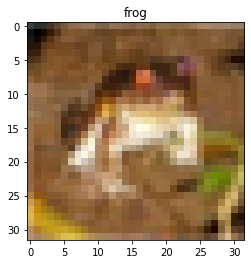

In [7]:
item = 0
plt.imshow(train_images[item].reshape(3, 32, 32).transpose(1, 2, 0))
plt.title(label_names[train_labels[item]])
plt.show()

What a beatiful frog!

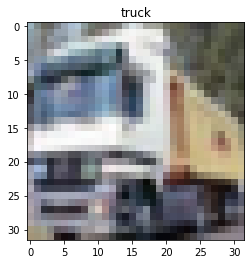

In [8]:
item = 1
plt.imshow(train_images[item].reshape(3, 32, 32).transpose(1, 2, 0))
plt.title(label_names[train_labels[item]])
plt.show()

And a trucking truck.

In [9]:
# find the indices of for 10 images of each label
indices = {}
for label in label_names:
    indices[label] = np.where(train_labels == label_names.index(label))[0][:10]
    print(label, indices[label])

airplane [ 29  30  35  49  77  93 115 116 129 165]
automobile [ 4  5 32 44 45 46 60 61 64 65]
bird [ 6 13 18 24 41 42 47 48 54 55]
cat [ 9 17 21 26 33 36 38 39 59 74]
deer [ 3 10 20 28 34 58 66 82 86 89]
dog [ 27  40  51  56  70  81  83 107 128 148]
frog [  0  19  22  23  25  72  95 103 104 117]
horse [ 7 11 12 37 43 52 68 73 84 85]
ship [  8  62  69  92 100 106 111 135 139 155]
truck [ 1  2 14 15 16 31 50 53 67 71]


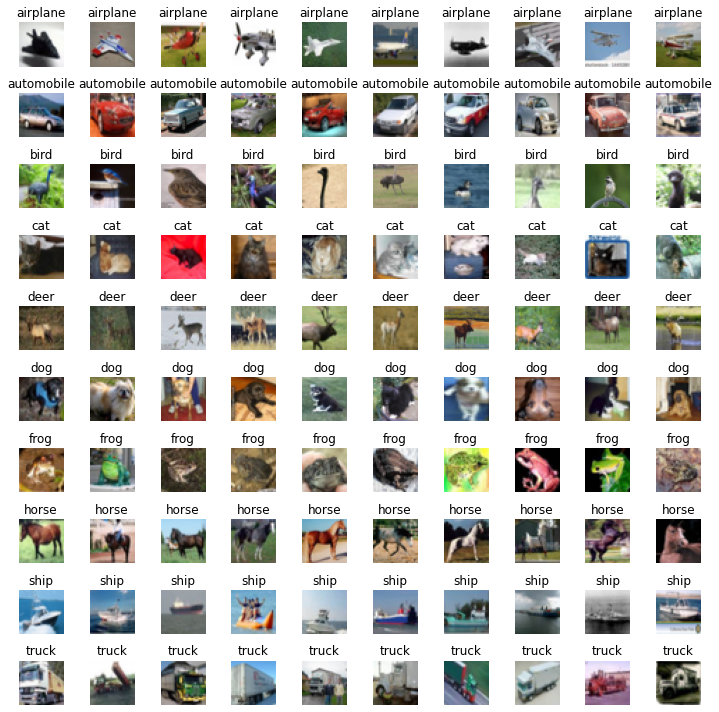

In [10]:
# plot 10 images of each label
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i, label in enumerate(label_names):
    for j, index in enumerate(indices[label]):
        axs[i, j].imshow(train_images[index].reshape(3, 32, 32).transpose(1, 2, 0))
        #if j == 0:
        axs[i, j].set_title(label)
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

# Preprocessing
Da der Datensatz schon sehr gut aufbereitet ist (gleiche Bildergrösse, von jedem Label gleichviel Bilder) müssen nur zwei Preprocessing Schritte durchgeführt werden:
 - Daten als PyTorch Tensor laden
 - Normalisieren

In [11]:
# convert to tensor and normalize the data using pytorch
train_images = torch.from_numpy(train_images).float()
train_labels = torch.from_numpy(train_labels).long()
test_images = torch.from_numpy(test_images).float()
test_labels = torch.from_numpy(test_labels).long()

# normalize the data to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Aufbau Modell
Metriken zur Evaluierung des Modells (inkl. deren Fehler in der Schätzung):
 - Accuracy
 - Precision
 - Recall
 - F1-Score
 - Confusion Matrix
 - ROC Curve
 - AUC

TODO: Berücksichtige auch den Fehler in der Schätzung dieser Metriken

## Modelle

### CNN

In [4]:
def conv_block(in_f, out_f, conv_kernel_size, conv_stride, conv_padding,
               pool_kernel_size, pool_stride, pool_padding, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, conv_kernel_size, conv_stride, conv_padding, *args, **kwargs),
        # nn.BatchNorm2d(out_f),
        nn.ReLU(),
        nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding)
    )

#### Big CNN

In [5]:
bigCNN = nn.Sequential(
    OrderedDict([
    ('conv1', conv_block(3, 16, conv_kernel_size=3, conv_stride=1, conv_padding=1,
                         pool_kernel_size=2, pool_stride=2, pool_padding=0)),
    ('conv2', conv_block(16, 32, conv_kernel_size=3, conv_stride=1, conv_padding=1,
                            pool_kernel_size=2, pool_stride=2, pool_padding=0)),
    ('conv3', conv_block(32, 64, conv_kernel_size=3, conv_stride=1, conv_padding=1,
                            pool_kernel_size=2, pool_stride=2, pool_padding=0)),
    ('avgpool', nn.AdaptiveAvgPool2d(1)),
    ('flatten', nn.Flatten()),
    ('fc1', nn.Sequential(nn.Linear(64, 32), nn.ReLU())),
    ('fc2', nn.Sequential(nn.Linear(32, 16), nn.ReLU())),
    ('fc3', nn.Sequential(nn.Linear(16, 10), nn.LogSoftmax(dim=1)))
    ])
)

print(bigCNN)

Sequential(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1):

#### medium CNN

In [6]:
mediumCNN = nn.Sequential(
    OrderedDict([
    ('conv1', conv_block(3, 16, conv_kernel_size=3, conv_stride=1, conv_padding=1,
                            pool_kernel_size=2, pool_stride=2, pool_padding=0)),
    ('conv2', conv_block(16, 32, conv_kernel_size=3, conv_stride=1, conv_padding=1,
                            pool_kernel_size=2, pool_stride=2, pool_padding=0)),
    ('avgpool', nn.AdaptiveAvgPool2d(1)),
    ('flatten', nn.Flatten()),
    ('fc1', nn.Sequential(nn.Linear(32, 16), nn.ReLU())),
    ('fc2', nn.Sequential(nn.Linear(16, 10), nn.LogSoftmax(dim=1)))
    ])
)

print(mediumCNN)

Sequential(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


#### small CNN

In [7]:

smallCNN = nn.Sequential(
    OrderedDict([
    ('conv1', conv_block(3, 16, conv_kernel_size=3, conv_stride=1, conv_padding=1,
                            pool_kernel_size=2, pool_stride=2, pool_padding=0)),
    ('avgpool', nn.AdaptiveAvgPool2d(1)),
    ('flatten', nn.Flatten()),
    ('fc1', nn.Sequential(nn.Linear(16, 10), nn.LogSoftmax(dim=1)))
    ])
)

print(smallCNN)

Sequential(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


### MLP

#### big MLP

In [8]:
bigMLP = nn.Sequential(
    OrderedDict([
    ('flatten', nn.Flatten()),
    ('fc1', nn.Sequential(nn.Linear(32 * 32 * 3, 1024), nn.ReLU())),
    ('fc2', nn.Sequential(nn.Linear(1024, 512), nn.ReLU())),
    ('fc3', nn.Sequential(nn.Linear(512, 256), nn.ReLU())),
    ('fc4', nn.Sequential(nn.Linear(256, 128), nn.ReLU())),
    ('fc5', nn.Sequential(nn.Linear(128, 64), nn.ReLU())),
    ('fc6', nn.Sequential(nn.Linear(64, 10), nn.LogSoftmax(dim=1)))
    ])
)

print(bigMLP)

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc5): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc6): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


#### small MLP

In [11]:
def SmallMLP():
    return nn.Sequential(
        OrderedDict([
        ('flatten', nn.Flatten()),
        ('fc1', nn.Sequential(nn.Linear(32 * 32 * 3, 256), nn.ReLU())),
        ('fc2', nn.Sequential(nn.Linear(256, 32), nn.ReLU())),
        ('fc3', nn.Sequential(nn.Linear(32, 10), nn.LogSoftmax(dim=1)))
        ])
    )

print(SmallMLP())

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


# train- and test function

In [39]:
def train(model, train_loader, device, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data, target = data.view(-1, 3, 32, 32), target
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [40]:
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAUROC, MulticlassConfusionMatrix

# TODO custom metrics class for wandb confusion matrix

def test(model, test_loader, device, criterion, classes):
    model.eval()
    test_loss = 0
    ground_truth = []
    predictions = []
    
    accuracy = MulticlassAccuracy(num_classes=len(classes), device=device)
    precision = MulticlassPrecision(num_classes=len(classes), device=device)
    recall = MulticlassRecall(num_classes=len(classes), device=device)
    f1 = MulticlassF1Score(num_classes=len(classes), device=device)
    aucroc = MulticlassAUROC(num_classes=len(classes), device=device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=len(classes), device=device)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            ground_truth.append(target)

            output = model(data)
            predictions.append(output)

            test_loss += criterion(output, target).item() # sum up batch loss

            pred = output.argmax(dim=1) # get the index of the max log-probability

            for metric in [accuracy, precision, recall, f1]:
                metric.update(pred, target)
            aucroc.update(output, target)
            confusion_matrix.update(output, target)
    test_loss /= len(test_loader.dataset)

    wandb.log({#"examples": example_images,
                "Test Accuracy": accuracy.compute(),
                "Test Precision": precision.compute(),
                "Test Recall": recall.compute(),
                "Test F1": f1.compute(),
                "Test AUROC": aucroc.compute(),
                # "roc" : wandb.plot.roc_curve( ground_truth, predictions,
                #         labels=classes),

                #"Test Confusion Matrix": wandb.plot.confusion_matrix(
                 #   preds=accuracy.
                    # TODO
                "Test Loss": test_loss})

In [41]:
from sklearn.model_selection import KFold
from time import time

config = {
    "batch_size": 1024,
    "test_batch_size": 10,
    "epochs": 50,
    "criterion": "CrossEntropyLoss",
    "lr": 0.1,
    "momentum": 0.1,
    "cuda": True,
    "seed": 42,
    "log_interval": 10,
    "n_splits": 3,
    "shuffle": True,
}

group = f"k-fold-run-{config['n_splits']}-splits-{time():.0f}"

kfold = KFold(n_splits = config["n_splits"], shuffle = config["shuffle"], random_state = config["seed"])

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_images)):
    print(f"Fold {fold}")
    t_images, val_images = train_images[train_ids], train_images[test_ids]
    t_labels, val_labels = train_labels[train_ids], train_labels[test_ids]

    with wandb.init(entity="florin-barbisch", project="del-mc1", group=group, config=config, tags=["developing"]) as run:
        use_cuda = config["cuda"] and torch.cuda.is_available()
        if config["cuda"] & use_cuda != config["cuda"]:
            print("WARNING: You don't have a CUDA device, so you are running on CPU.")
        device = torch.device("cuda" if use_cuda else "cpu")
        kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


        torch.manual_seed(config["seed"]) 

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(t_images, t_labels),
            batch_size=config["batch_size"], shuffle=True, **kwargs)

        test_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(val_images, val_labels),
            batch_size=config["batch_size"], shuffle=False, **kwargs)

        model = SmallCNN().to(device)
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
        criterion = nn.CrossEntropyLoss()

        wandb.watch(model, log="all")

        for epoch in range(1, config["epochs"] + 1):
            train(model, train_loader, device, optimizer, criterion, epoch)
            test(model, test_loader, device, criterion, label_names)
        
        wandb.log({"one metric": 0.5, "another metric": 0.7, "etc": 0.9})


Fold 0


Train Epoch: 1 [0/33333 (0%)]	Loss: 2.301427
Train Epoch: 2 [0/33333 (0%)]	Loss: 2.301993
Train Epoch: 3 [0/33333 (0%)]	Loss: 2.299075
Train Epoch: 4 [0/33333 (0%)]	Loss: 2.290593
Train Epoch: 5 [0/33333 (0%)]	Loss: 2.252313
Train Epoch: 6 [0/33333 (0%)]	Loss: 2.322015
Train Epoch: 7 [0/33333 (0%)]	Loss: 2.291776
Train Epoch: 8 [0/33333 (0%)]	Loss: 2.207081
Train Epoch: 9 [0/33333 (0%)]	Loss: 2.080317
Train Epoch: 10 [0/33333 (0%)]	Loss: 2.037439
Train Epoch: 11 [0/33333 (0%)]	Loss: 2.086872
Train Epoch: 12 [0/33333 (0%)]	Loss: 1.956252
Train Epoch: 13 [0/33333 (0%)]	Loss: 2.061053
Train Epoch: 14 [0/33333 (0%)]	Loss: 2.250907
Train Epoch: 15 [0/33333 (0%)]	Loss: 1.799199
Train Epoch: 16 [0/33333 (0%)]	Loss: 1.729819
Train Epoch: 17 [0/33333 (0%)]	Loss: 1.715317
Train Epoch: 18 [0/33333 (0%)]	Loss: 1.704203
Train Epoch: 19 [0/33333 (0%)]	Loss: 1.549590
Train Epoch: 20 [0/33333 (0%)]	Loss: 1.629190
Train Epoch: 21 [0/33333 (0%)]	Loss: 1.820007
Train Epoch: 22 [0/33333 (0%)]	Loss: 1.6930

Test AUROC,▁▂▂▂▁▁▃▃▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▇███████
Test Accuracy,▁▁▁▂▂▂▄▄▄▃▃▅▅▅▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
Test F1,▁▁▁▂▂▂▄▄▄▃▃▅▅▅▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
Test Loss,█████▇▇▆▆▆█▅▄▄▃▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁
Test Precision,▁▁▁▂▂▂▄▄▄▃▃▅▅▅▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
Test Recall,▁▁▁▂▂▂▄▄▄▃▃▅▅▅▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
another metric,▁
etc,▁
one metric,▁
Test AUROC,0.9182
Test Accuracy,0.55073


Fold 1


Train Epoch: 1 [0/33333 (0%)]	Loss: 2.303296
Train Epoch: 2 [0/33333 (0%)]	Loss: 2.301819
Train Epoch: 3 [0/33333 (0%)]	Loss: 2.298017
Train Epoch: 4 [0/33333 (0%)]	Loss: 2.289230
Train Epoch: 5 [0/33333 (0%)]	Loss: 2.245484
Train Epoch: 6 [0/33333 (0%)]	Loss: 2.278176
Train Epoch: 7 [0/33333 (0%)]	Loss: 2.091075
Train Epoch: 8 [0/33333 (0%)]	Loss: 2.047035
Train Epoch: 9 [0/33333 (0%)]	Loss: 2.025343
Train Epoch: 10 [0/33333 (0%)]	Loss: 1.973664
Train Epoch: 11 [0/33333 (0%)]	Loss: 1.903355
Train Epoch: 12 [0/33333 (0%)]	Loss: 1.834763
Train Epoch: 13 [0/33333 (0%)]	Loss: 1.790950
Train Epoch: 14 [0/33333 (0%)]	Loss: 1.747216
Train Epoch: 15 [0/33333 (0%)]	Loss: 1.678458
Train Epoch: 16 [0/33333 (0%)]	Loss: 1.695119
Train Epoch: 17 [0/33333 (0%)]	Loss: 1.689772
Train Epoch: 18 [0/33333 (0%)]	Loss: 1.512070
Train Epoch: 19 [0/33333 (0%)]	Loss: 2.165148
Train Epoch: 20 [0/33333 (0%)]	Loss: 1.611926
Train Epoch: 21 [0/33333 (0%)]	Loss: 1.450132
Train Epoch: 22 [0/33333 (0%)]	Loss: 1.5125

Test AUROC,▁▂▂▂▃▃▃▄▄▅▅▅▆▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
Test Accuracy,▁▁▁▁▃▃▃▄▅▅▅▅▆▆▃▆▆▇▇▇▇▇▇▇▇▇█▇████████████
Test F1,▁▁▁▁▃▃▃▄▅▅▅▅▆▆▃▆▆▇▇▇▇▇▇▇▇▇█▇████████████
Test Loss,████▇▆▆▆▅▅▄▄▄▃▇▃▃▃▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁▁▁▁▃▃▃▄▅▅▅▅▆▆▃▆▆▇▇▇▇▇▇▇▇▇█▇████████████
Test Recall,▁▁▁▁▃▃▃▄▅▅▅▅▆▆▃▆▆▇▇▇▇▇▇▇▇▇█▇████████████
another metric,▁
etc,▁
one metric,▁
Test AUROC,0.91807
Test Accuracy,0.54821


Fold 2


Train Epoch: 1 [0/33334 (0%)]	Loss: 2.303206
Train Epoch: 2 [0/33334 (0%)]	Loss: 2.301447
Train Epoch: 3 [0/33334 (0%)]	Loss: 2.298037
Train Epoch: 4 [0/33334 (0%)]	Loss: 2.290332
Train Epoch: 5 [0/33334 (0%)]	Loss: 2.257881
Train Epoch: 6 [0/33334 (0%)]	Loss: 2.183605
Train Epoch: 7 [0/33334 (0%)]	Loss: 2.241238
Train Epoch: 8 [0/33334 (0%)]	Loss: 2.036310
Train Epoch: 9 [0/33334 (0%)]	Loss: 1.948425
Train Epoch: 10 [0/33334 (0%)]	Loss: 1.903704
Train Epoch: 11 [0/33334 (0%)]	Loss: 1.910173
Train Epoch: 12 [0/33334 (0%)]	Loss: 1.967188
Train Epoch: 13 [0/33334 (0%)]	Loss: 1.867928
Train Epoch: 14 [0/33334 (0%)]	Loss: 1.763624
Train Epoch: 15 [0/33334 (0%)]	Loss: 1.698124
Train Epoch: 16 [0/33334 (0%)]	Loss: 1.768332
Train Epoch: 17 [0/33334 (0%)]	Loss: 1.589458
Train Epoch: 18 [0/33334 (0%)]	Loss: 1.806067
Train Epoch: 19 [0/33334 (0%)]	Loss: 1.573057
Train Epoch: 20 [0/33334 (0%)]	Loss: 1.590125
Train Epoch: 21 [0/33334 (0%)]	Loss: 1.536946
Train Epoch: 22 [0/33334 (0%)]	Loss: 1.5280

Test AUROC,▁▂▂▂▂▃▃▄▄▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
Test Accuracy,▁▁▂▂▂▃▄▄▄▄▅▅▆▄▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████
Test F1,▁▁▂▂▂▃▄▄▄▄▅▅▆▄▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████
Test Loss,█████▇▆▆▆▅▅▄▄▅▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▂
Test Precision,▁▁▂▂▂▃▄▄▄▄▅▅▆▄▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████
Test Recall,▁▁▂▂▂▃▄▄▄▄▅▅▆▄▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████
another metric,▁
etc,▁
one metric,▁
Test AUROC,0.9162
Test Accuracy,0.55022


In [17]:
wandb.finish()